ThinkDSP
========

This notebook contains code examples from Chapter 10: Signals and Systems

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

Impulse response
--
To understand why the impulse response is sufficient to characterize a system, it is informative to look at the DFT of an impulse:

In [3]:
from thinkdsp import Wave

impulse = np.zeros(8)
impulse[0] = 1
wave = Wave(impulse, framerate=8)
print(wave.ys)

[1. 0. 0. 0. 0. 0. 0. 0.]


The DFT of an impulse is all ones, which means that the impulse contains equal energy at all frequencies.  So testing a system with an impulse is like testing it will all frequency components at the same time:

In [4]:
impulse_spectrum = wave.make_spectrum(full=True)
print(impulse_spectrum.hs)

[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]


You might notice something about the impulse and its DFT:

In [5]:
np.sum(wave.ys**2)

1.0

In [6]:
np.sum(impulse_spectrum.hs**2)

(8+0j)

In general, the total magnitue of DFT(y) is N times the total magnitude of y.


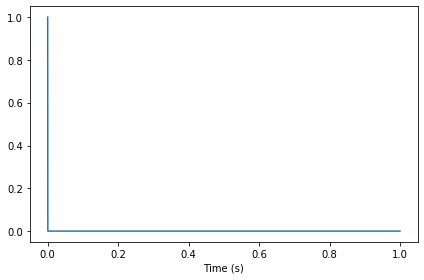

In [7]:
impulse = np.zeros(10000)
impulse[0] = 1
wave = Wave(impulse, framerate=10000)
wave.plot()
decorate(xlabel='Time (s)')

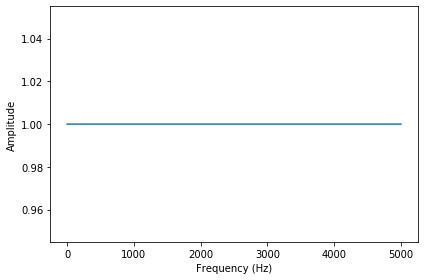

In [8]:
wave.make_spectrum().plot()
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

System characterization
--

Let's look at a mini example of system characterization.  Suppose you have a system that smooths the signal by taking a moving average of adjacent elements:

In [9]:
window_array = np.array([0.5, 0.5, 0, 0, 0, 0, 0, 0,])
window = Wave(window_array, framerate=8)

For this moving average window, we can compute the transfer function:

In [10]:
filtr = window.make_spectrum(full=True)
print(filtr.hs)

[1.        +0.j         0.85355339-0.35355339j 0.5       -0.5j
 0.14644661-0.35355339j 0.        +0.j         0.14644661+0.35355339j
 0.5       +0.5j        0.85355339+0.35355339j]


Here are the magnitudes:

In [11]:
filtr.amps

array([1.        , 0.92387953, 0.70710678, 0.38268343, 0.        ,
       0.38268343, 0.70710678, 0.92387953])

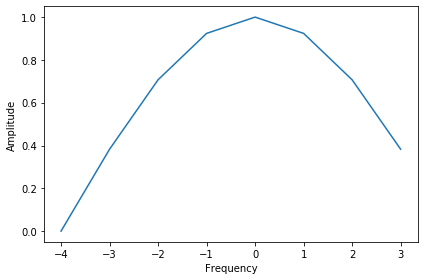

In [12]:
filtr.plot()
decorate(xlabel='Frequency', ylabel='Amplitude')

If you multiply the transfer function by the spectrum of an impulse (which is all ones), the result is the filter:

In [13]:
product = impulse_spectrum * filtr
print(product.hs)

[1.        +0.j         0.85355339-0.35355339j 0.5       -0.5j
 0.14644661-0.35355339j 0.        +0.j         0.14644661+0.35355339j
 0.5       +0.5j        0.85355339+0.35355339j]


In [14]:
np.max(np.abs(product.hs - filtr.hs))

0.0

Now if you transform back to the time domain, you have the impulse response, which looks a lot like the window:

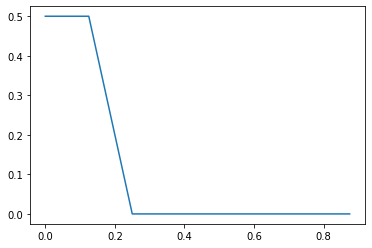

In [15]:
filtered = product.make_wave()
filtered.plot()
decorate(xlabel='Time')

In [16]:
print(filtered.ys.real)

[ 5.00000000e-01  5.00000000e-01  0.00000000e+00  2.77555756e-17
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.77555756e-17]


This example is meant to demonstrate why a recording of an impulse response is sufficient to characterize a system: because it is the IDFT of the transfer function.

Acoustic impulse response
--

Here's a recording of a gunshot, which approximates the acoustic impulse response of the room:

In [18]:
if not os.path.exists('180960__kleeb__gunshot.wav'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/180960__kleeb__gunshot.wav

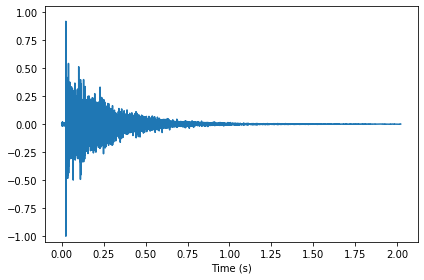

In [19]:
from thinkdsp import read_wave

response = read_wave('180960__kleeb__gunshot.wav')

start = 0.12
response = response.segment(start=start)
response.shift(-start)

response.normalize()
response.plot()
decorate(xlabel='Time (s)')

Here's what it sounds like:

In [20]:
response.make_audio()

The DFT of the impulse response is the transfer function:

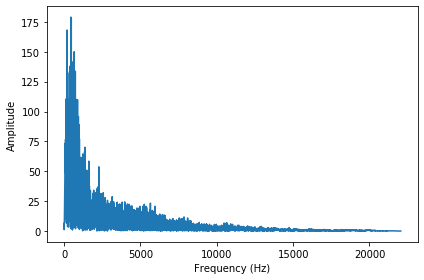

In [21]:
transfer = response.make_spectrum()
transfer.plot()
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

Here's the transfer function on a log-log scale:

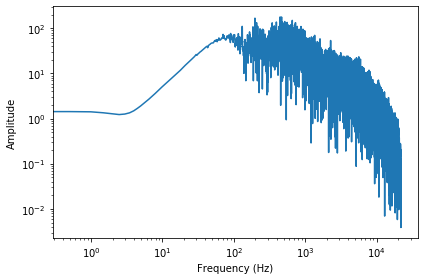

In [22]:
transfer.plot()
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude',
         xscale='log', yscale='log')

Now we can simulate what a recording would sound like if it were played in the same room and recorded in the same way.  Here's the violin recording we have used before:

In [23]:
if not os.path.exists('92002__jcveliz__violin-origional.wav'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/92002__jcveliz__violin-origional.wav

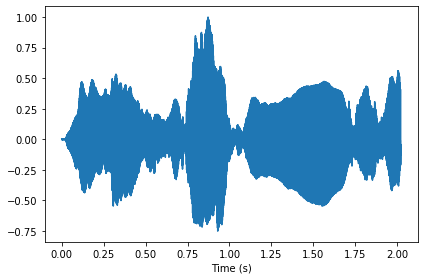

In [25]:
violin = read_wave('92002__jcveliz__violin-origional.wav')

start = 0.11
violin = violin.segment(start=start)
violin.shift(-start)

violin.truncate(len(response))
violin.normalize()
violin.plot()
decorate(xlabel='Time (s)')

Here's what it sounds like before transformation:

In [26]:
violin.make_audio()

Now we compute the DFT of the violin recording.

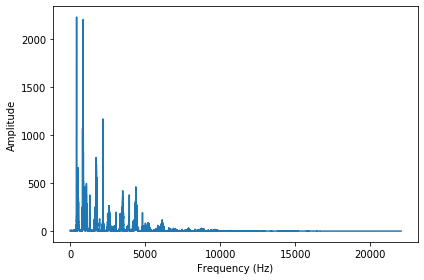

In [27]:
spectrum = violin.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

I trimmed the violin recording to the same length as the impulse response:

In [28]:
len(spectrum.hs), len(transfer.hs)

(44554, 44554)

We we can multiply in the frequency domain and the transform back to the time domain.

In [29]:
output = (spectrum * transfer).make_wave()
output.normalize()

Here's a  comparison of the original and transformed recordings:

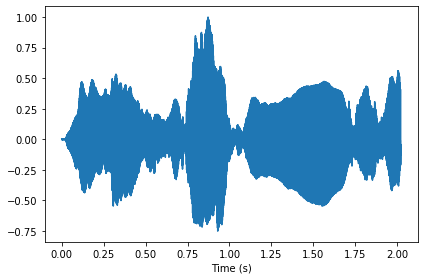

In [30]:
violin.plot()
decorate(xlabel='Time (s)')

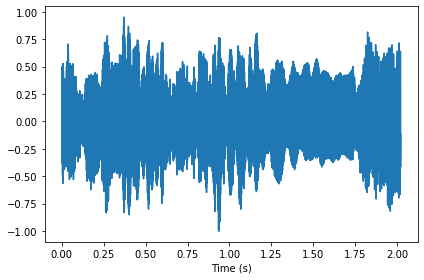

In [31]:
output.plot()
decorate(xlabel='Time (s)')

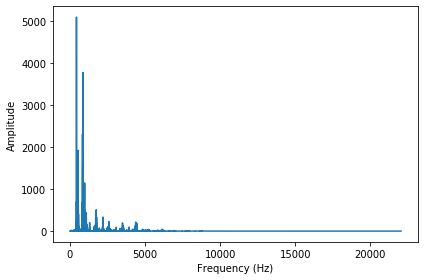

In [32]:
spectrum = output.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

And here's what it sounds like:

In [33]:
output.make_audio()

At the beginning of the output, you might notice an extra note that has wrapped around from the end.  The reason is that multiplication in the frequency domain corresponds to *circular* convolution, which assumes that the signal is periodic.  When the signal is not periodic, we can avoid wrap-around by padding the signal with zeros.

Convolution
--

To understand how that worked, you can think about the input signal as a series of impulses, and the output as the sum of shifted, scaled versions of the impulse response.

In [34]:
def shifted_scaled(wave, shift, factor):
    """Make a shifted, scaled copy of a wave.
    
    wave: Wave
    shift: time shift, float
    factor: multiplier, float
    """
    res = wave.copy()
    res.shift(shift)
    res.scale(factor)
    return res

Here's what it would sound like if we fired a big gun followed by a small gun:

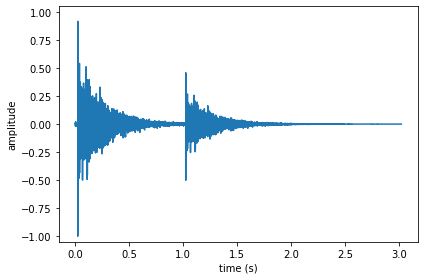

In [35]:
dt = 1
factor = 0.5

response2 = response + shifted_scaled(response, dt, factor)
response2.plot()
decorate(xlabel='Time (s)', ylabel='Amplitude')

Two gunshots:

In [36]:
response2.make_audio()

Adding up shifted, scaled copies of the impulse response doesn't always sounds like gunshots.  If there are enough of them, close enough together, it sounds like a wave.

Here's what it sounds like if we fire 220 guns at a rate of 441 gunshots per second:

In [37]:
dt = 1 / 441
total = 0
for k in range(220):
    total += shifted_scaled(response, k*dt, 1.0)
total.normalize()

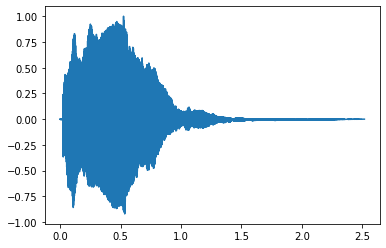

In [38]:
total.plot()

Here's what it sounds like:

In [39]:
total.make_audio()

To me it sounds a bit like a car horn in a garage.


We can do the same thing with an arbitrary input signal.

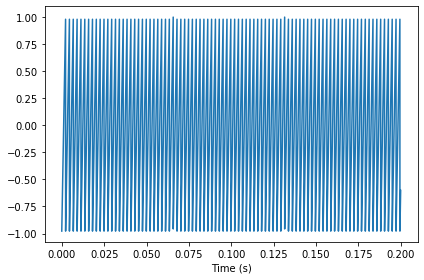

In [42]:
from thinkdsp import SawtoothSignal

signal = SawtoothSignal(freq=441)
wave = signal.make_wave(duration=0.2, framerate=response.framerate)
wave.plot()
decorate(xlabel='Time (s)')

And here's what we get if we use the wave to generate shifted, scaled versions of the impulse response:

In [43]:
total = 0
for t, y in zip(wave.ts, wave.ys):
    total += shifted_scaled(response, t, y)
total.normalize()

The result is a simulation of what the wave would sound like if it was recorded in the room where the gunshot was recorded:

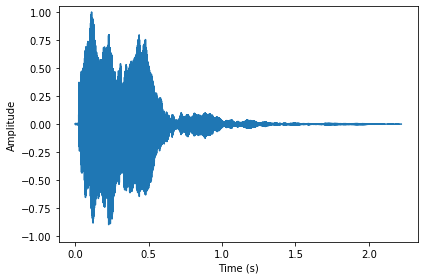

In [44]:
total.plot()
decorate(xlabel='Time (s)', ylabel='Amplitude')

And here's what it sounds like:

In [45]:
total.make_audio()

Here's a comparison of the spectrum before and after convolution:

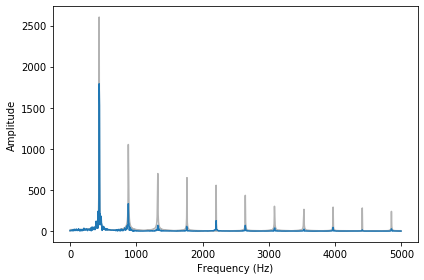

In [46]:
high = 5000
wave.make_spectrum().plot(high=high, color='0.7')

segment = total.segment(duration=0.2)
segment.make_spectrum().plot(high=high)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

Now that we recognize this operation as convolution, we can compute it using the convolve method:

In [47]:
convolved = wave.convolve(response)
convolved.normalize()
convolved.make_audio()

And we can do the same thing with the violin recording:

In [48]:
convolved2 = violin.convolve(response)
convolved2.normalize()
convolved2.make_audio()

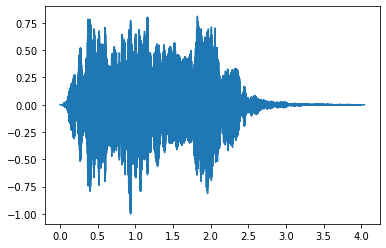

In [49]:
convolved2.plot()